In [2]:
import os

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim

from model.datamarts.ImageDatamart import ImageDatamart


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BatchSize = 10
Epochs = 30
ImageSize = (50, 50)
DatamartDir = "datamart"
ModelDir = 'models/'

{'Glioma': 1283, 'Meningioma': 637, 'Pituitary tumor': 837}
['Glioma', 'Meningioma', 'Pituitary tumor']


<BarContainer object of 3 artists>

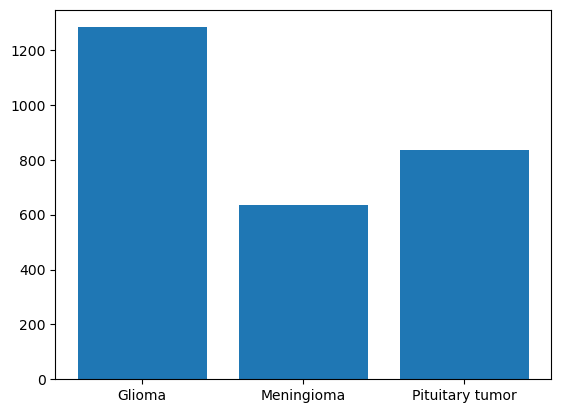

In [5]:
datamart = ImageDatamart(DatamartDir)

print(datamart.data_per_category())
print(datamart.categories())
plt.bar(datamart.data_per_category().keys(), datamart.data_per_category().values())

In [6]:
from model.dataframes.ImageDataframe import ImageDataframe

dataframe = ImageDataframe(datamart)
print(dataframe.get().keys())
print(len(list(dataframe.get().values())[0]), len(list(dataframe.get().values())[1]))

dict_keys(['Input', 'Output'])
2757 2757


In [7]:
dataframe.load_images()

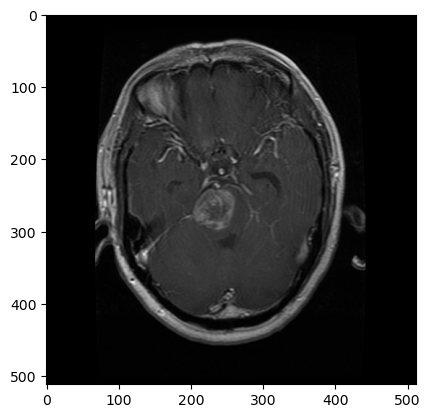

In [8]:
plt.imshow(dataframe.get()["Input"][100].content())

In [9]:
from model.mappers.ResizeImageMapper import ResizeImageMapper

resizer = ResizeImageMapper(ImageSize)
resizer.apply(dataframe, column_name="Input", output_column_name="Resized Input")

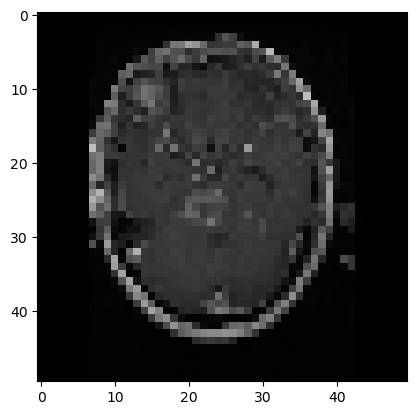

In [12]:
plt.imshow(dataframe.get()["Resized Input"][100].content())

In [13]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    transforms.Resize(size=(ImageSize[0], ImageSize[1])),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root="datamart",
                                  transform=data_transform)

test_data = datasets.ImageFolder(root="sources/DatasetTumoresCerebrales/test",
                                 transform=data_transform)


train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BatchSize,
                              num_workers=1,
                              shuffle=True)

test_dataloader =  DataLoader(dataset=test_data,
                              batch_size=BatchSize,
                              num_workers=1,
                              shuffle=True)


In [14]:
# Definimos el modelo
from torch import nn
from torchinfo  import summary

# creamos la red feed-forward
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected,self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(ImageSize[0]*ImageSize[0]*3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = FullyConnected().to(device)


In [15]:
from torch import optim

# definimos la métrica y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# función de entrenamiento
def train(dataloader, model, loss_fn, optimizer, losses, accuracy):
    size = len(dataloader.dataset)

    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            train_acc = 100*correct / size
            losses.append(loss.item())
            print(f"Accuracy: {train_acc:>0.1f}%, Avg loss: {loss.item():>8f} [{current:>5d}/{size:>5d}]")

    train_acc = 100*correct/size
    accuracy.append(train_acc)


# función de test
def test(dataloader, model, loss_fn, losses, accuracy):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc = 100*correct/size
    losses.append(test_loss)
    accuracy.append(test_acc)
    print(f"Test Error: \n Accuracy: {test_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
# bucle de entranamiento
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(Epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)

print("Done!")


Epoch 1
-------------------------------
Accuracy: 0.3%, Avg loss: 1.097923 [   10/ 2757]
Accuracy: 26.0%, Avg loss: 0.699259 [ 1010/ 2757]
Accuracy: 50.6%, Avg loss: 0.634967 [ 2010/ 2757]
Test Error: 
 Accuracy: 73.0%, Avg loss: 0.560411 

Epoch 2
-------------------------------
Accuracy: 0.2%, Avg loss: 0.636505 [   10/ 2757]
Accuracy: 26.1%, Avg loss: 0.269621 [ 1010/ 2757]
Accuracy: 51.7%, Avg loss: 0.426055 [ 2010/ 2757]
Test Error: 
 Accuracy: 72.6%, Avg loss: 0.582256 

Epoch 3
-------------------------------
Accuracy: 0.3%, Avg loss: 0.181137 [   10/ 2757]
Accuracy: 26.6%, Avg loss: 0.334866 [ 1010/ 2757]
Accuracy: 53.2%, Avg loss: 1.057306 [ 2010/ 2757]
Test Error: 
 Accuracy: 74.6%, Avg loss: 0.505745 

Epoch 4
-------------------------------
Accuracy: 0.3%, Avg loss: 0.569073 [   10/ 2757]
Accuracy: 28.0%, Avg loss: 0.472600 [ 1010/ 2757]
Accuracy: 54.8%, Avg loss: 0.638656 [ 2010/ 2757]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.468345 

Epoch 5
----------------------------

In [20]:
torch.save(model.state_dict(), ModelDir+"FC-model.pth")

In [31]:
import matplotlib.pyplot as plt

def draw_graphics(neural_network, train_loss, train_acc, test_acc):

    # Dibujamos las gráficas
    x = range(len(train_loss))
    plt.figure()
    plt.plot(x,train_loss, color='blue')
    plt.legend(['Train Loss'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(ModelDir + neural_network + '-train_loss.svg')

    plt.figure()
    plt.plot(train_acc, color='blue')
    plt.plot(test_acc, color='red')
    plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig(ModelDir + neural_network + '-Accuracy.svg')


In [ ]:
draw_graphics("FC", train_loss, train_acc, test_acc)


In [49]:
# Definimos las redes convolucionales
from torch import nn
from torchinfo import summary

def bloque_conv(in_features, out_features):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

def bloque_conv_norm(in_features, out_features):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, 1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = bloque_conv(3, 32)
        self.conv2 = bloque_conv(32, 64)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7744, 3)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        logits = self.linear_out(x)
        return logits


class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = bloque_conv_norm(3, 32)
        self.conv2 = bloque_conv_norm(32, 64)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(7744, 3),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        logits = self.linear_out(x)
        return logits


class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = bloque_conv_norm(3, 32)
        self.conv2 = bloque_conv_norm(32, 64)
        self.conv3 = bloque_conv_norm(64, 128)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 3),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        logits = self.linear_out(x)
        return logits


In [36]:
model = ConvNet1()
model.to(device)

ConvNet1(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7744, out_features=3, bias=True)
  )
)

In [37]:
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# bucle principal
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(Epochs):
    print(f"Epoch {t+1}/{Epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)

print("Done!")

Epoch 1/30
-------------------------------
Accuracy: 0.1%, Avg loss: 1.103059 [   10/ 2757]
Accuracy: 22.8%, Avg loss: 0.509396 [ 1010/ 2757]
Accuracy: 50.0%, Avg loss: 0.866392 [ 2010/ 2757]
Test Error: 
 Accuracy: 70.4%, Avg loss: 0.618112 

Epoch 2/30
-------------------------------
Accuracy: 0.2%, Avg loss: 0.922758 [   10/ 2757]
Accuracy: 30.6%, Avg loss: 0.565909 [ 1010/ 2757]
Accuracy: 62.5%, Avg loss: 0.137525 [ 2010/ 2757]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.328836 

Epoch 3/30
-------------------------------
Accuracy: 0.3%, Avg loss: 0.214631 [   10/ 2757]
Accuracy: 32.3%, Avg loss: 0.108727 [ 1010/ 2757]
Accuracy: 65.0%, Avg loss: 0.961583 [ 2010/ 2757]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.364491 

Epoch 4/30
-------------------------------
Accuracy: 0.4%, Avg loss: 0.081029 [   10/ 2757]
Accuracy: 33.7%, Avg loss: 0.275257 [ 1010/ 2757]
Accuracy: 65.8%, Avg loss: 0.286735 [ 2010/ 2757]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.375000 

Epoch 5/30
-------------

In [39]:
torch.save(model.state_dict(), ModelDir + "model_cnn1.pth")

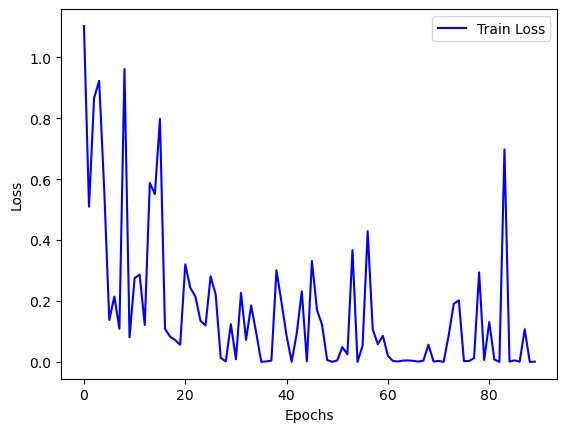

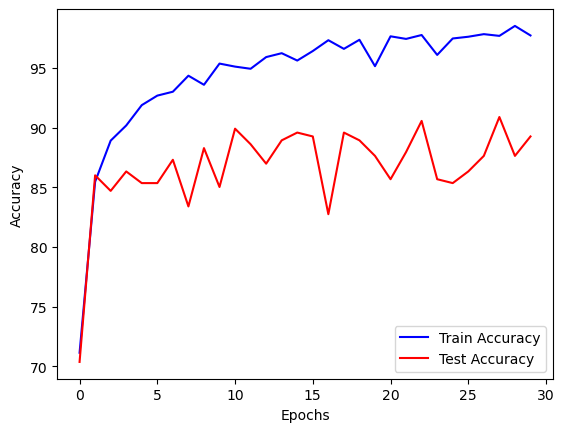

In [38]:
draw_graphics("cnn1",train_loss, train_acc, test_acc)

In [43]:
model = ConvNet2()
model.to(device)

ConvNet2(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=7744, out_features=3, bias=True)
  )
)

In [44]:
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# bucle principal
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(Epochs):
    print(f"Epoch {t+1}/{Epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)

print("Done!")

Epoch 1/30
-------------------------------
Accuracy: 0.3%, Avg loss: 0.722939 [   10/ 2757]
Accuracy: 24.3%, Avg loss: 0.731888 [ 1010/ 2757]
Accuracy: 50.7%, Avg loss: 2.170069 [ 2010/ 2757]
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.532505 

Epoch 2/30
-------------------------------
Accuracy: 0.3%, Avg loss: 0.604993 [   10/ 2757]
Accuracy: 29.0%, Avg loss: 1.206989 [ 1010/ 2757]
Accuracy: 58.4%, Avg loss: 0.352623 [ 2010/ 2757]
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.383263 

Epoch 3/30
-------------------------------
Accuracy: 0.4%, Avg loss: 0.176741 [   10/ 2757]
Accuracy: 30.7%, Avg loss: 0.969986 [ 1010/ 2757]
Accuracy: 61.0%, Avg loss: 0.313066 [ 2010/ 2757]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.548317 

Epoch 4/30
-------------------------------
Accuracy: 0.3%, Avg loss: 0.429928 [   10/ 2757]
Accuracy: 31.7%, Avg loss: 0.205783 [ 1010/ 2757]
Accuracy: 62.2%, Avg loss: 0.466719 [ 2010/ 2757]
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.432621 

Epoch 5/30
-------------

In [46]:
torch.save(model.state_dict(), ModelDir + "model_cnn2.pth")

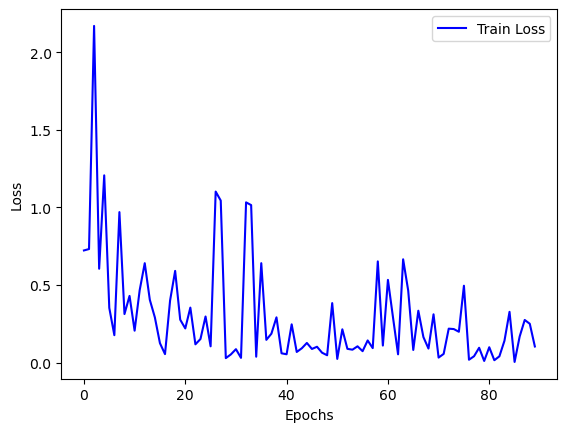

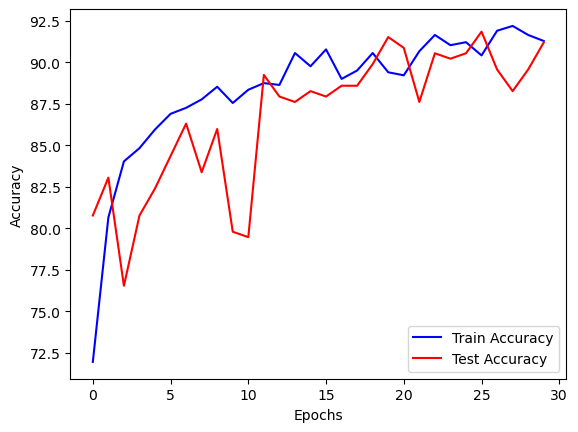

In [45]:
draw_graphics("cnn2", train_loss, train_acc, test_acc)

In [50]:
model = ConvNet3()
model.to(device)

ConvNet3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=3, bias=True)
  )
)

In [51]:
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# bucle principal
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(Epochs):
    print(f"Epoch {t+1}/{Epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)

print("Done!")

Epoch 1/30
-------------------------------
Accuracy: 0.2%, Avg loss: 1.167208 [   10/ 2757]
Accuracy: 24.4%, Avg loss: 0.305169 [ 1010/ 2757]
Accuracy: 52.7%, Avg loss: 0.357142 [ 2010/ 2757]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.526702 

Epoch 2/30
-------------------------------
Accuracy: 0.3%, Avg loss: 0.545759 [   10/ 2757]
Accuracy: 29.7%, Avg loss: 0.222341 [ 1010/ 2757]
Accuracy: 60.1%, Avg loss: 0.233535 [ 2010/ 2757]
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.391821 

Epoch 3/30
-------------------------------
Accuracy: 0.3%, Avg loss: 0.443176 [   10/ 2757]
Accuracy: 31.7%, Avg loss: 0.075317 [ 1010/ 2757]
Accuracy: 63.4%, Avg loss: 0.404918 [ 2010/ 2757]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.448012 

Epoch 4/30
-------------------------------
Accuracy: 0.4%, Avg loss: 0.028848 [   10/ 2757]
Accuracy: 33.6%, Avg loss: 0.748022 [ 1010/ 2757]
Accuracy: 65.9%, Avg loss: 0.327011 [ 2010/ 2757]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.406591 

Epoch 5/30
-------------

In [54]:
torch.save(model.state_dict(), ModelDir + "model_cnn3.pth")

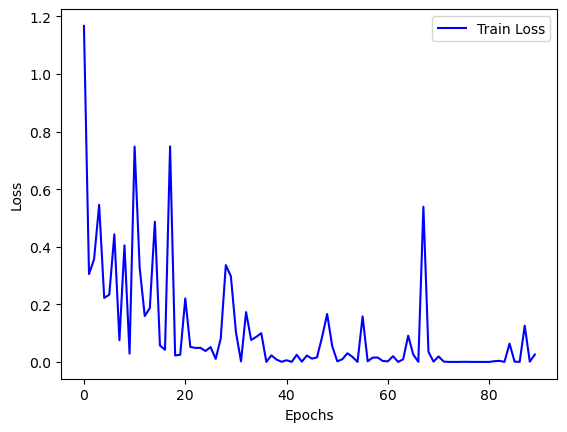

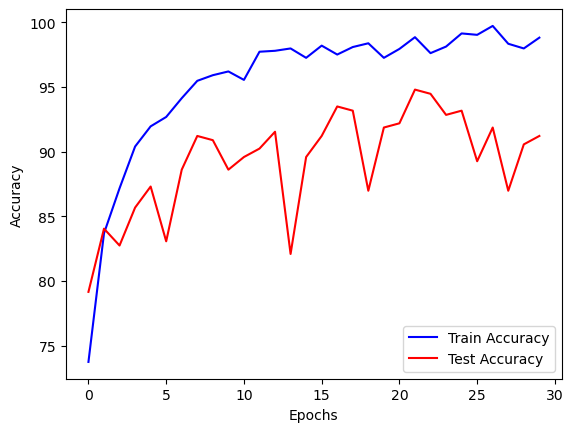

In [55]:
draw_graphics("cnn3", train_loss, train_acc, test_acc)

In [73]:
from torchvision.models import resnet18
from torchvision.transforms import Grayscale, ToTensor, Compose

model = resnet18()

# Cambiamos la capa superior con una capa Lineal con el número de clases
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(in_features=num_features,
                    out_features=3,
                    bias=True)).to(device)

summary(model,
        input_size=(BatchSize, 3, BatchSize, BatchSize),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [10, 3, 10, 10]      [10, 3]              --                   True
├─Conv2d (conv1)                         [10, 3, 10, 10]      [10, 64, 5, 5]       9,408                True
├─BatchNorm2d (bn1)                      [10, 64, 5, 5]       [10, 64, 5, 5]       128                  True
├─ReLU (relu)                            [10, 64, 5, 5]       [10, 64, 5, 5]       --                   --
├─MaxPool2d (maxpool)                    [10, 64, 5, 5]       [10, 64, 3, 3]       --                   --
├─Sequential (layer1)                    [10, 64, 3, 3]       [10, 64, 3, 3]       --                   True
│    └─BasicBlock (0)                    [10, 64, 3, 3]       [10, 64, 3, 3]       --                   True
│    │    └─Conv2d (conv1)               [10, 64, 3, 3]       [10, 64, 3, 3]       36,864               True
│    │    └─BatchN

In [74]:
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# bucle principal
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(50):
    print(f"Epoch {t+1}/{50}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)

print("Done!")

Epoch 1/50
-------------------------------
Accuracy: 0.1%, Avg loss: 1.689594 [   10/ 2757]
Accuracy: 18.9%, Avg loss: 0.669918 [ 1010/ 2757]
Accuracy: 41.9%, Avg loss: 0.637302 [ 2010/ 2757]
Test Error: 
 Accuracy: 67.1%, Avg loss: 1.516641 

Epoch 2/50
-------------------------------
Accuracy: 0.2%, Avg loss: 0.628080 [   10/ 2757]
Accuracy: 24.6%, Avg loss: 0.551440 [ 1010/ 2757]
Accuracy: 49.6%, Avg loss: 3.412259 [ 2010/ 2757]
Test Error: 
 Accuracy: 72.6%, Avg loss: 0.892902 

Epoch 3/50
-------------------------------
Accuracy: 0.3%, Avg loss: 0.345752 [   10/ 2757]
Accuracy: 25.2%, Avg loss: 0.815486 [ 1010/ 2757]
Accuracy: 51.2%, Avg loss: 0.767881 [ 2010/ 2757]
Test Error: 
 Accuracy: 73.0%, Avg loss: 0.666996 

Epoch 4/50
-------------------------------
Accuracy: 0.4%, Avg loss: 0.102193 [   10/ 2757]
Accuracy: 26.9%, Avg loss: 0.345011 [ 1010/ 2757]
Accuracy: 54.6%, Avg loss: 0.329497 [ 2010/ 2757]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.556910 

Epoch 5/50
-------------

In [76]:
torch.save(model.state_dict(), ModelDir + "model_resnet18.pth")

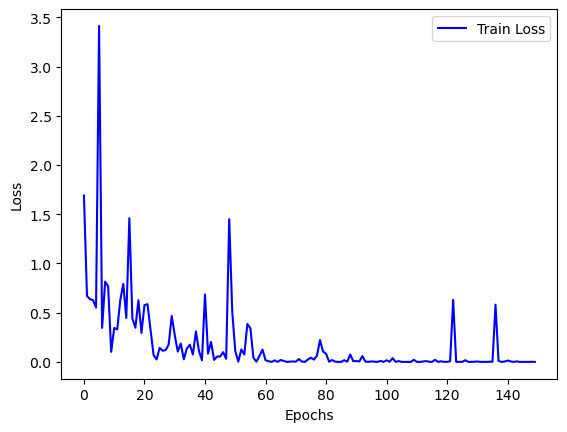

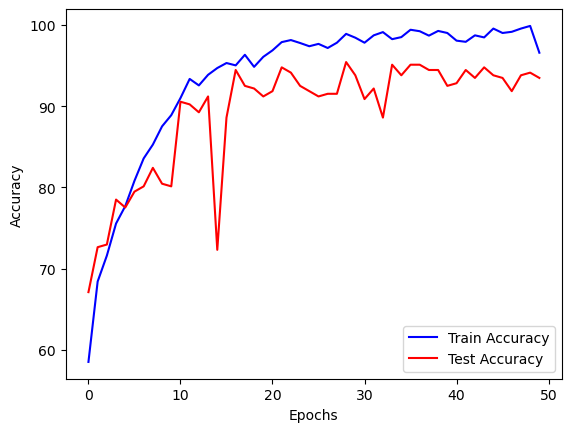

In [75]:
draw_graphics("resnet18", train_loss, train_acc, test_acc)